# Cancerous Gene Classification

* This problem statement was taken from https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview

* Download the datasets **'training_text'** & **'training_variants'** from https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

**Summary of the code below:**
1. Importing dependencies and acquiring data
2. Performing EDA and Data Pre-processing
3. Splitting the dataset into train, cross-validation and test sets
4. Performing hyper-parameter tuning over the cross-validation set for each model namely, Logistic Regression, Linear SVM and Random Forest.


* *The metric used to evaluate and compare the results of the models was **log-loss**.*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re
import math
from nltk.corpus import stopwords
import pdb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


Data Acquisition

In [2]:
data = pd.read_csv('training_variants')
print(data.shape)
data.head()

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
print('Number of classes: ',data.Class.unique())

Number of classes:  [1 2 3 4 5 6 7 8 9]


Thus, the gene-variation pairs will get classified into 9 different classes

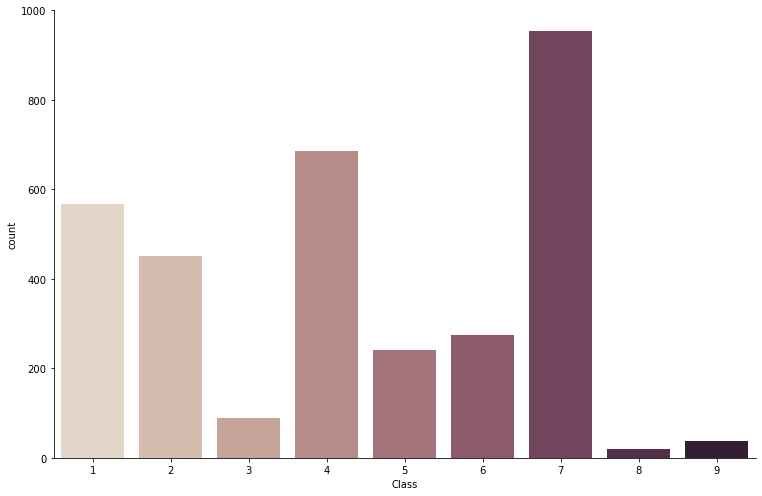

In [4]:
sb.catplot(x="Class", kind="count", palette="ch:.25", data=data, height = 7, aspect = 1.5)

**Since the distribution of classes is skewed, we have to maintain this disb. throughout the train, cv and test sets**

---------------------------

In [5]:
'''
Looking at the data we see that ID and Text are not seperated by commas, but rather '||' wiz. a double pipe delimited file
as mentioned in the kaggle page, which we have to seperate over to avoid the parse error. Also, the first line is the 
column names but they're not assigned correctly. Hence, we need to skip that row and assign the values normally.

referenced the parsing from https://stackoverflow.com/questions/58707332/parsing-a-double-pipe-delimited-file-in-python
'''

text_data = pd.read_csv('training_text',sep='\|\|', names=['ID','Text'], skiprows=1)

print(text_data.shape)
text_data.head()

(3321, 2)


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


-----------------------------

Data Pre-processing

In [6]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

# referenced from https://stackoverflow.com/questions/23996118/replace-special-characters-in-a-string-python
# and https://pythonexamples.org/python-replace-multiple-spaces-with-single-space-in-text-file/

def clean_text(corpus):
        
    if type(corpus) is not int:
        a = ""
        text = re.sub('[^a-zA-Z0-9\n]',' ',corpus)
        text = re.sub('\s+',' ',corpus)
        text = text.lower()
        
        for word in text.split():
            
            if word in stop_words:
                a += ''
            else:
                a += word + " "
        
        return a

In [7]:
ids = text_data['ID'].copy()
index = 0
for i in text_data.Text:
    #pdb.set_trace()
    if type(i) is str:
        x = clean_text(i)
        text_data['Text'][index] = x
    else:
        b = ids[index]
        print(f'Text NA for ID:{b}')
    index+=1

Text NA for ID:1109
Text NA for ID:1277
Text NA for ID:1407
Text NA for ID:1639
Text NA for ID:2755


In [8]:
text_data.head()

,ID,Text
0,0,cyclin-dependent kinases (cdks) regulate varie...
1,1,abstract background non-small cell lung cancer...
2,2,abstract background non-small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b-lineag...


In [9]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, text_data, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin-dependent kinases (cdks) regulate varie...
1,1,CBL,W802*,2,abstract background non-small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non-small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b-lineag...


In [10]:
result.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [11]:
a = result[result.isnull().any(axis=1)].copy()
a

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [12]:
pd.options.display.min_rows = 20
b = result.groupby('Gene')['Gene'].count()
b
b.sort_values(ascending = False)

Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
         ... 
PPM1D       1
PMS1        1
PIK3R3      1
PAX8        1
ERRFI1      1
PAK1        1
FAM58A      1
FANCC       1
FGF19       1
KLF4        1
Name: Gene, Length: 264, dtype: int64

In [13]:
# referenced from https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/

for i,j in a.iterrows():
    count = 0
    for k,v in result.iterrows():
        #pdb.set_trace()
        if (j['Gene'] == v['Gene']) & (j['Variation'] == v['Variation']):
            count+=1
    if count >= 1:
        print('The count of the pair of {} and {} is {}'.format(j['Gene'],j['Variation'], count))

The count of the pair of FANCA and S1088F is 1
The count of the pair of ARID5B and Truncating Mutations is 1
The count of the pair of FGFR3 and K508M is 1
The count of the pair of FLT1 and Amplification is 1
The count of the pair of BRAF and G596C is 1


* We see that the above pairs having no supporting text are only present once throughout the dataset. If we remove these rows then we could loose their classification (especially for class 6 as they are less in count throughout the dataset) 

*Instead of removing these gene-variation pairs, we can just replace the NaN with the gene and variation name in the respective 'Text' field.* 

In [14]:
result.loc[result['Text'].isnull(),'Text'] = result['Gene'] +' '+result['Variation']

In [15]:
result[result['ID']==2755]

,ID,Gene,Variation,Class,Text
2755,2755,BRAF,G596C,7,BRAF G596C


In [16]:
len(result)

3321

In [17]:
'''
Since, we're to do onehot encoding for the features, it is better that we replace the spaces in gene and variation 
feature with an underscore

'''

strat_disb = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# using stratify will help us here to maintain the same distribution of class labels in our subsets as well

X_train, x_test, train_y, y_test = train_test_split(result, strat_disb, stratify=strat_disb, test_size=0.2, random_state=60)
x_train, x_cv, y_train, y_cv = train_test_split(X_train, train_y, stratify=train_y, test_size=0.2, random_state=60)

In [18]:
# featurization of the text feature using one hot encoding (tfidf) 
# limiting the featurization to those words which occur atleast 3 times in the corpus

text_tfidf = TfidfVectorizer(min_df=3)
text_tfidf.fit(x_train['Text'])
train_text = text_tfidf.transform(x_train['Text'])
train_text = normalize(train_text, axis=0)

# using the same vectorizer that was trained on train data

cv_text = text_tfidf.transform(x_cv['Text'])
cv_text = normalize(cv_text, axis=0)

test_text = text_tfidf.transform(x_test['Text'])
test_text = normalize(test_text, axis=0)

In [19]:
# featurization of the gene and variation features using one hot encoding 

gene_ohe = CountVectorizer()
train_gene = gene_ohe.fit_transform(x_train['Gene'])
train_gene = normalize(train_gene, axis=0)

cv_gene = gene_ohe.transform(x_cv['Gene'])
cv_gene = normalize(cv_gene, axis=0)

test_gene = gene_ohe.transform(x_test['Gene'])
test_gene = normalize(test_gene, axis=0)

#---------------------------------------------------------------------------------------------------------------------#

variation_ohe = CountVectorizer()
train_variation = variation_ohe.fit_transform(x_train['Variation'])
train_variation = normalize(train_variation, axis=0)

cv_variation = variation_ohe.transform(x_cv['Variation'])
cv_variation = normalize(cv_variation, axis=0)

test_variation = variation_ohe.transform(x_test['Variation'])
test_variation = normalize(test_variation, axis=0)

In [20]:
print(train_gene.shape)
print(train_variation.shape)
print(train_text.shape)

(2124, 233)
(2124, 1974)
(2124, 56489)


In [21]:
x_train_final = hstack((train_gene, train_variation, train_text)).tocsr()
y_train_final = np.array(list(x_train['Class']))

x_cv_final = hstack((cv_gene, cv_variation, cv_text)).tocsr()
y_cv_final = np.array(list(x_cv['Class']))

x_test_final = hstack((test_gene, test_variation, test_text)).tocsr()
y_test_final = np.array(list(x_test['Class']))

In [22]:
print(x_train_final.shape)
print(x_test_final.shape)
print(x_cv_final.shape)

(2124, 58696)
(665, 58696)
(532, 58696)


# Logistic Regression

Hyper-parameter tuning

In [23]:
# Using SGD Classifier with loss argument as log loss so that it functions as a Logistic Regression
# Using 'balanced' class_weight here to maintain the ratio of the classes
'''
Since we do not want a blackbox model and want to classify the mutations with utmost certainty we use CalibratedClassifierCV. 
referenced from https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
''' 
alpha = [10 ** x for x in range(-5, 2)]
list_log_loss = []
for i in alpha:
    print("For alpha =", i)
    logistic = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=60)
    logistic.fit(x_train_final, y_train_final)
    prob_logistic = CalibratedClassifierCV(logistic)
    prob_logistic.fit(x_train_final, y_train_final)
    prob_x_cv = prob_logistic.predict_proba(x_cv_final)
    list_log_loss.append(log_loss(y_cv_final, prob_x_cv, labels=logistic.classes_)) 
    
    # to avoid rounding error while multiplying probabilites I used log-probability estimates
    print("CV log Loss :",log_loss(y_cv_final, prob_x_cv))

For alpha = 1e-05
CV log Loss : 1.2554856827616867
For alpha = 0.0001
CV log Loss : 1.1013905238914352
For alpha = 0.001
CV log Loss : 1.165879328943427
For alpha = 0.01
CV log Loss : 1.2518909495939732
For alpha = 0.1
CV log Loss : 1.4005614924980676
For alpha = 1
CV log Loss : 1.560547384571933
For alpha = 10
CV log Loss : 1.5931389097786206


-----------------------

Modelling with the best value of alpha

In [24]:
best_alpha = np.argmin(list_log_loss)
logistic = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=60)
logistic.fit(x_train_final, y_train_final)
prob_logistic = CalibratedClassifierCV(logistic, method="sigmoid")
prob_logistic.fit(x_train_final, y_train_final)

print('For the value of best alpha =', alpha[best_alpha])
prob_final_train = prob_logistic.predict_proba(x_train_final) 
print('\nTrain log loss :',log_loss(y_train_final, prob_final_train, labels=logistic.classes_))
prob_final_cv = prob_logistic.predict_proba(x_cv_final)
print('Cross Validation log loss :',log_loss(y_cv_final, prob_final_cv, labels=logistic.classes_))
prob_final_test = prob_logistic.predict_proba(x_test_final)
print('Test log loss :',log_loss(y_test_final, prob_final_test, labels=logistic.classes_))

For the value of best alpha = 0.0001

Train log loss : 0.5428493957402157
Cross Validation log loss : 1.1013905238914352
Test log loss : 1.069329304971553


In [25]:
pred_labels = []
for i in prob_final_test:
    i = list(i)
    pos = i.index(max(i))
    pred_labels.append(pos+1)

print("Misclassification %age :", np.count_nonzero((pred_labels - y_test_final))/y_test_final.shape[0])

Misclassification %age : 0.35037593984962406


In [26]:
test_point_index = 5
predicted_class = prob_logistic.predict(x_test_final[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(prob_logistic.predict_proba(x_test_final[test_point_index]),2))
print("Actual Class :", y_test_final[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.89 0.03 0.01 0.01 0.02 0.01 0.02 0.01 0.01]]
Actual Class : 1


# Linear SVM

Hyper-parameter tuning

In [27]:
# Since we have used the loss argument as 'hinge', it will function as an **SVM Classifier**

c = [10 ** x for x in range(-5, 3)]
list_log_loss = []
for i in c:
    print("For C =", i)
#    svc = SVC(C=i,kernel='linear',probability=True, class_weight='balanced', random_state = 42)
    svc = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=60)
    svc.fit(x_train_final, y_train_final)
    prob_svc = CalibratedClassifierCV(svc, method="sigmoid")
    prob_svc.fit(x_train_final, y_train_final)
    prob_x_cv = prob_svc.predict_proba(x_cv_final)
    list_log_loss.append(log_loss(y_cv_final, prob_x_cv, labels=svc.classes_, eps=1e-15))
    print("CV log Loss :",log_loss(y_cv_final, prob_x_cv)) 


For C = 1e-05
CV log Loss : 1.2888112114505472
For C = 0.0001
CV log Loss : 1.2341552428671316
For C = 0.001
CV log Loss : 1.130969643092841
For C = 0.01
CV log Loss : 1.242584803512788
For C = 0.1
CV log Loss : 1.4057934721134888
For C = 1
CV log Loss : 1.5963262909367837
For C = 10
CV log Loss : 1.5961996011305433
For C = 100
CV log Loss : 1.5961992802457856


----------------

Modelling with the best value of alpha

In [28]:
best_alpha = np.argmin(list_log_loss)
svc = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=60)
svc.fit(x_train_final, y_train_final)
prob_svc = CalibratedClassifierCV(svc, method="sigmoid")
prob_svc.fit(x_train_final, y_train_final)

print('For values of best alpha = ', alpha[best_alpha])
prob_final_train = prob_svc.predict_proba(x_train_final) 
print('\nTrain log loss :',log_loss(y_train_final, prob_final_train, labels=svc.classes_))
prob_final_cv = prob_svc.predict_proba(x_cv_final)
print('Cross Validation log loss :',log_loss(y_cv_final, prob_final_cv, labels=svc.classes_))
prob_final_test = prob_svc.predict_proba(x_test_final)
print('Test log loss :',log_loss(y_test_final, prob_final_test, labels=svc.classes_))

For values of best alpha =  0.001

Train log loss : 0.6078792833811073
Cross Validation log loss : 1.130969643092841
Test log loss : 1.1197654783603976


In [29]:
pred_labels = []
for i in prob_final_test:
    i = list(i)
    pos = i.index(max(i))
    pred_labels.append(pos+1)

print("Misclassification %age :", np.count_nonzero((pred_labels - y_test_final))/y_test_final.shape[0])

Misclassification %age : 0.3518796992481203


In [30]:
test_point_index = 5
predicted_class = prob_svc.predict(x_test_final[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(prob_svc.predict_proba(x_test_final[test_point_index]),2))
print("Actual Class :", y_test_final[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.84 0.04 0.   0.04 0.02 0.   0.05 0.   0.01]]
Actual Class : 1


# Random Forest

Hyper-parameter tuning

In [32]:
n_est = [100,200,500,1000,2000]
list_log_loss = []
for i in n_est:
        print("for n_estimators =", i)
        rf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=10, random_state=60, n_jobs=-1)
        rf.fit(x_train_final, y_train_final)
        prob_rf = CalibratedClassifierCV(rf, method="sigmoid")
        prob_rf.fit(x_train_final, y_train_final)
        prob_cv_rf = prob_rf.predict_proba(x_cv_final)
        list_log_loss.append(log_loss(y_cv_final, prob_cv_rf, labels=rf.classes_, eps=1e-15))
        print("CV log Loss :",log_loss(y_cv_final, prob_cv_rf)) 

for n_estimators = 100
CV log Loss : 1.239328435179232
for n_estimators = 200
CV log Loss : 1.2296648304669864
for n_estimators = 500
CV log Loss : 1.2221892286188227
for n_estimators = 1000
CV log Loss : 1.2189293146494184
for n_estimators = 2000
CV log Loss : 1.2176029595437161


We notice that there isnt much difference in the log loss values of (n_estimators = 500 & max_depth = 10) and (n_estimators = 2000 & max_depth = 10), but there is a big difference in the time complexity of the two. Hence, we select the best pair to be n_estimaotrs = 500 and max_depth = 10 as it has lower time complexity.

------------------------

Modellling with the best value of estimators and max_depth

In [33]:
rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10, random_state=60, n_jobs=-1)
rf.fit(x_train_final, y_train_final)
prob_rf = CalibratedClassifierCV(rf, method="sigmoid")
prob_rf.fit(x_train_final, y_train_final)

print('For values of best estimator = ', 1000) 
prob_final_train = prob_rf.predict_proba(x_train_final)
print('\nTrain log loss :',log_loss(y_train_final, prob_final_train, labels=rf.classes_))
prob_final_cv = prob_rf.predict_proba(x_cv_final)
print('Cross Validation log loss :',log_loss(y_cv_final, prob_final_cv, labels=rf.classes_))
prob_final_test = prob_rf.predict_proba(x_test_final)
print('Test log loss :',log_loss(y_test_final, prob_final_test, labels=rf.classes_))

For values of best estimator =  1000

Train log loss : 0.6342129238888813
Cross Validation log loss : 1.2189293146494184
Test log loss : 1.1526961241417986


In [34]:
pred_labels = []
for i in prob_final_test:
    i = list(i)
    pos = i.index(max(i))
    pred_labels.append(pos+1)

print("Misclassification %age :", np.count_nonzero((pred_labels - y_test_final))/y_test_final.shape[0])

Misclassification %age : 0.37142857142857144


In [35]:
test_point_index = 5
predicted_class = prob_rf.predict(x_test_final[test_point_index])
print("Predicted Class :", predicted_class[0])
print("Predicted Class Probabilities:", np.round(prob_rf.predict_proba(x_test_final[test_point_index]),2))
print("Actual Class :", y_test_final[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.5  0.06 0.02 0.24 0.05 0.04 0.07 0.01 0.01]]
Actual Class : 1


------------------------------------------

**The best result from all the three models was from *'Logistic Regression'*, probably because of Logistic Regression's ablility to handle large dimensional dataset better.**